In [1]:
import os

os.environ['OPENBLAS_NUM_THREADS'] = '25'
os.environ['MKL_NUM_THREADS'] = '25'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime as dt
import copy
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import xarray as xr
import pickle
import random
import time
import signal
import multiprocessing
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy import interpolate
import random
import lightgbm as lgb
import itertools
import joblib
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
sys.path.insert(1,'/home/jsperezc/jupyter/AQ_Forecast/functions/')
import postprocessing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit

import smogn
#from gbdtmo import GBDTMulti, load_lib

# 1. Read Data

In [2]:
data_pm25 = pd.read_csv('/var/data1/AQ_Forecast_DATA/historic/PM25/FullPM2.5.csv',index_col=0,parse_dates=True)
pd.DataFrame(data_pm25['MED-LAYE'])

,MED-LAYE
Fechas,
2016-01-01 00:00:00,30.0
2016-01-01 01:00:00,45.0
2016-01-01 02:00:00,24.0
2016-01-01 03:00:00,34.0
2016-01-01 04:00:00,27.0
...,...
2022-01-13 18:00:00,17.0
2022-01-13 19:00:00,27.0
2022-01-13 20:00:00,10.0


In [3]:
### PM2.5

data_pm25 = pd.read_csv('/var/data1/AQ_Forecast_DATA/historic/PM25/FullPM2.5.csv',index_col=0,parse_dates=True)
short_stations = ['SAB-JOFE','MED-UNNV','GIR-TEMP','GIR-SOSN','GIR-EPM','MED-FISC']
# data_pm25.index = data_pm25.index-dt.timedelta(hours = 1) 
#data_pm25 = data_pm25.drop(short_stations,axis = 1)
data_pm25 = pd.DataFrame(data_pm25['MED-LAYE'])
stations = np.sort(data_pm25.keys())

data_pm25_orig = data_pm25
data_pm25 = data_pm25['2017-10-01':'2020-04-01']

anomalous_stations = ['CEN-TRAF','SUR-TRAF']
#df_temp = data_pm25.drop(anomalous_stations,axis = 1)
data_pm25_copy = copy.deepcopy(data_pm25) ## Copy if I have to come back

def clean_abrupt_gradient(anoms):
    diff = abs(np.diff(anoms))
    anoms[np.hstack([diff>=1.5,np.array([False])])] = np.nan
    anoms[np.hstack([np.array([False]),diff>=1.5])] = np.nan
    return pd.Series(anoms,index = anoms.index)
#df_mean = pd.DataFrame(data_pm25.drop(anomalous_stations,axis = 1).mean(axis = 1))
df_mean = data_pm25.mean(axis = 1)
data_temp = copy.deepcopy(df_mean)
df_mean = data_temp
df_mean = pd.DataFrame(df_mean)
df_mean.columns = ['PM25_stations']


### CAMS

data_CAMS = postprocessing.call_files('CAMS')
data_CAMS = postprocessing.recorte_espacial(data_CAMS)

dataset_full = data_CAMS

lat_cams = dataset_full.latitude.values
lon_cams = dataset_full.longitude.values

aod = np.nanmean(dataset_full.aod550.values,axis = (1,2))#[:].data
bcaod = np.nanmean(dataset_full.bcaod550.values,axis = (1,2))#[:].data
pm2p5_cams = np.nanmean(dataset_full.pm2p5.values,axis = (1,2)) #* 1000_000_000

df_cams = pd.DataFrame(np.array([aod,bcaod,pm2p5_cams]).T,index= dataset_full.time.values,
    columns = ['aod','bcaod','pm2p5_cams'])
# df_cams = pd.DataFrame(np.array([aod,pm2p5_cams]).T,index= dataset_full.time.values,
#     columns = ['aod','pm2p5_cams'])
# df_cams = (df_cams.rolling(3,center=True).mean())
df_cams.index = df_cams.index - dt.timedelta(hours = 5)



df_CAMS_hourly = df_cams.resample('H').mean().interpolate(method = 'linear',order = 3)
df_CAMS_hourly.index = df_CAMS_hourly.index

df_hourly_chem = pd.concat([df_mean,df_CAMS_hourly],axis=1).dropna()

In [342]:
df_hourly_chem

,PM25_stations,aod,bcaod,pm2p5_cams
2017-10-01 00:00:00,6.0,0.204742,0.007460,19.352252
2017-10-01 01:00:00,8.0,0.209542,0.007401,18.890240
2017-10-01 02:00:00,11.0,0.204680,0.007233,18.551991
2017-10-01 03:00:00,11.0,0.199818,0.007066,18.213741
2017-10-01 04:00:00,6.0,0.194956,0.006898,17.875491
...,...,...,...,...
2020-04-01 19:00:00,24.0,0.512876,0.068201,24.188392
2020-04-01 20:00:00,6.0,0.527123,0.069406,25.180035
2020-04-01 21:00:00,18.0,0.541369,0.070611,26.171678
2020-04-01 22:00:00,19.0,0.555615,0.071816,27.163320


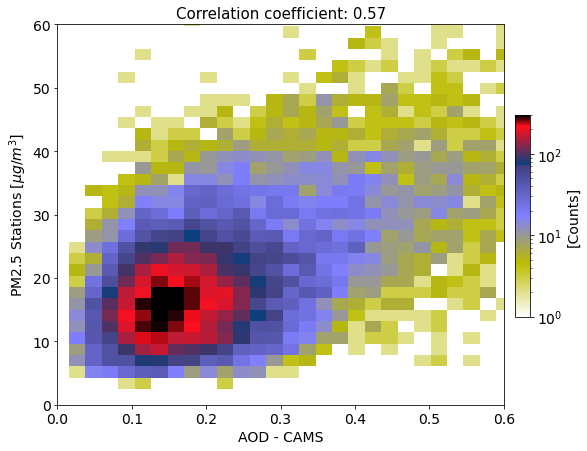

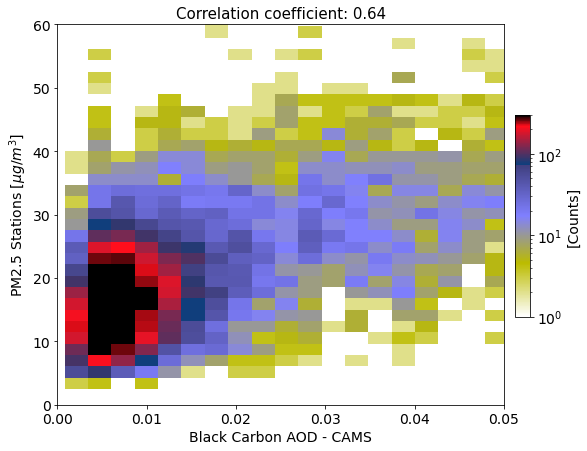

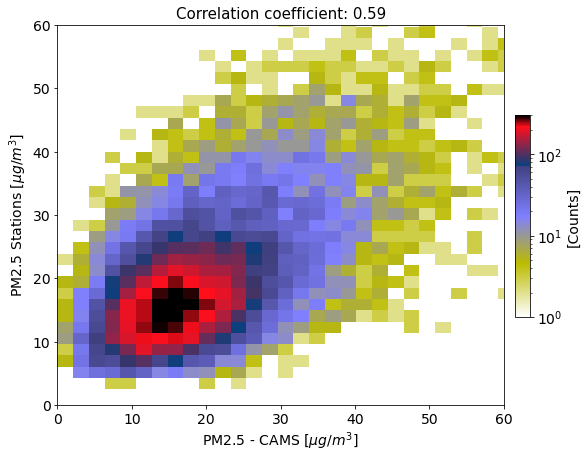

In [4]:
names_cams = ['AOD - CAMS','Black Carbon AOD - CAMS','PM2.5 - CAMS [$\mu g / m^3$]']

for i,var_cams in enumerate(df_hourly_chem.keys()[1:]):
    corr = np.corrcoef(df_hourly_chem[var_cams],df_hourly_chem.PM25_stations)[0][1]
    plt.figure(figsize=(8,7))
    CS = plt.hist2d(df_hourly_chem[var_cams],df_hourly_chem.PM25_stations,bins = [50,50],
                    cmap='gist_stern_r',vmax = 300,norm=LogNorm()
                   )
    plt.xlim(0,[0.6,0.05,60,60][i])
    plt.ylim(0,60)
    plt.title('Correlation coefficient: '+str(np.round(corr,2)),fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlabel(names_cams[i],fontsize=14)
    plt.ylabel('PM2.5 Stations [$\mu g / m^3$]',fontsize=14)
    # plt.legend(fontsize=16)

    cax = plt.axes([0.92, 0.3, 0.025, 0.4])
    cbar = plt.colorbar(CS[3], cax=cax)
    cbar.set_label(u'[Counts]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    plt.show()

In [4]:
df_GFS_hourly = pd.read_csv('/var/data1/AQ_Forecast_DATA/historic/GFS/GFS_Mean_Hourly_v2.csv',\
                            index_col = 0, parse_dates=True)
limits = [(70,100),(0,800),(0,1.2),(0,1500),(-30,0)]
colormaps_meteo = ['YlGnBu','YlOrBr','viridis_r','RdPu','plasma']
# keys_gfs = np.array(df_GFS_hourly.keys()).astype(str)
keys_gfs = ['tcc','rad','prate','hpbl','cin']
months_of_year_str = ['E','F','M','A','M','J','J','A','S','O','N','D']
units = ['%', 'W/m2', 'mm', 'm', 'J/kg']

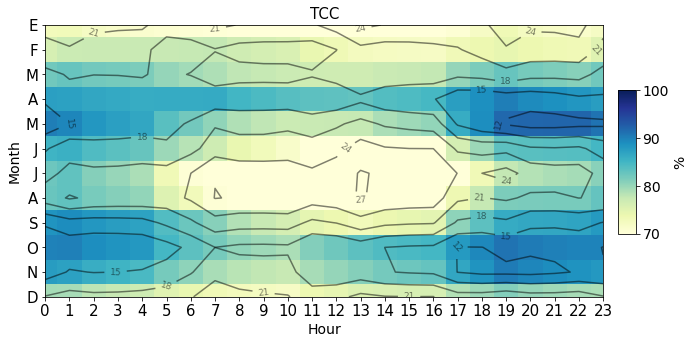

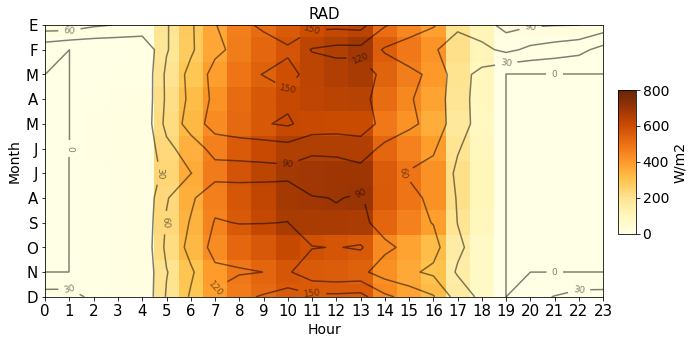

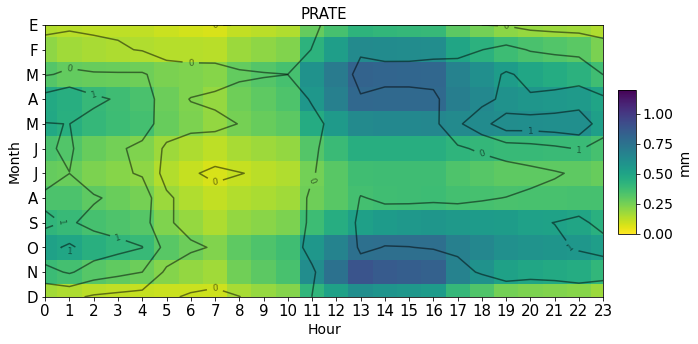

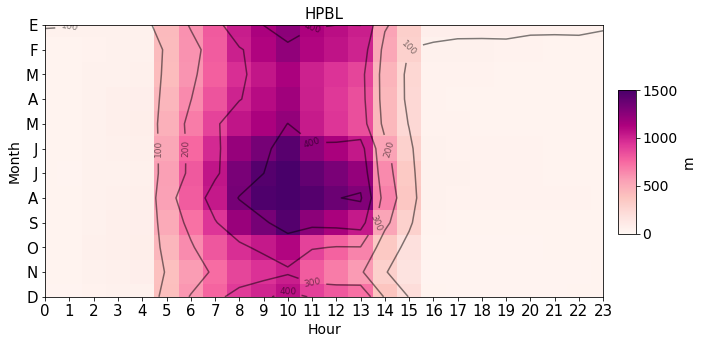

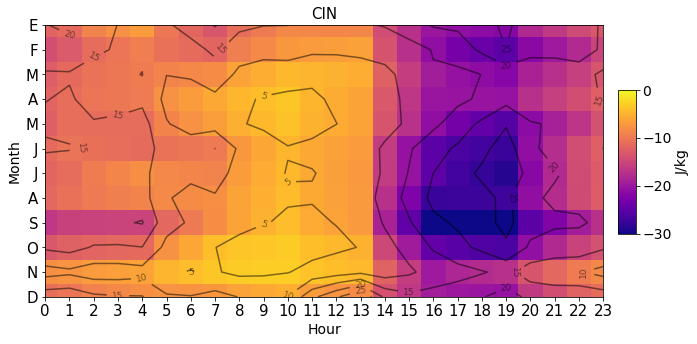

In [29]:
df_GFS_hourly = pd.read_csv('/var/data1/AQ_Forecast_DATA/historic/GFS/GFS_Mean_Hourly_v2.csv',\
                            index_col = 0, parse_dates=True)
limits = [(70,100),(0,800),(0,1.2),(0,1500),(-30,0)]
colormaps_meteo = ['YlGnBu','YlOrBr','viridis_r','RdPu','plasma']
# keys_gfs = np.array(df_GFS_hourly.keys()).astype(str)
keys_gfs = ['tcc','rad','prate','hpbl','cin']
months_of_year_str = ['E','F','M','A','M','J','J','A','S','O','N','D']
units = ['%', 'W/m2', 'mm', 'm', 'J/kg']

for ivariable in range(len(keys_gfs)):
    df_temp = df_GFS_hourly[keys_gfs[ivariable]]
    mean_temp = np.zeros([12,24])
    std_temp = np.zeros([12,24])
    for monthi in range(1,13):
        for houri in range(0,24):
            mean_temp[monthi-1,houri] = np.nanmean(df_temp[(df_temp.index.month == monthi)&\
                                                           (df_temp.index.hour == houri)])
            std_temp[monthi-1,houri] = np.nanstd(df_temp[(df_temp.index.month == monthi)&\
                                                           (df_temp.index.hour == houri)])

    months_of_year = np.arange(1,13)
    hours_of_day = np.arange(0,24)

    months_of_year_plot = np.arange(0.5,13.5,1)
    hours_of_day_plot = np.arange(-0.5,24,1)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    mini=limits[ivariable][0]
    maxi=limits[ivariable][1]
    intervals = 21
    bounds=np.linspace(mini,maxi,intervals)

    CS = plt.pcolormesh(hours_of_day_plot,months_of_year_plot,mean_temp,vmin=mini,vmax=maxi,\
                        cmap = colormaps_meteo[ivariable])
    CT = plt.contour(hours_of_day,months_of_year,std_temp,5,colors='k',alpha = 0.5)
    ax.clabel(CT, fontsize=9, inline=1,fmt = '%1.0f')
    plt.yticks(months_of_year,months_of_year_str,fontsize=15)
    plt.xticks(hours_of_day,hours_of_day,fontsize=15)
    plt.ylim(12,1)
    plt.xlim(0,23)

    plt.xlabel('Hour',fontsize=14)
    plt.ylabel('Month',fontsize=14)

    plt.title(keys_gfs[ivariable].upper(),fontsize=15)

    cax = plt.axes([0.92, 0.3, 0.025, 0.4])
    cbar = plt.colorbar(CS, cax=cax)
    cbar.set_label(units[ivariable],fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    plt.show()
#     plt.savefig('Figures/Characterization/Meteo/CACD_'+keys_gfs[ivariable]+'.png',bbox_inches='tight')

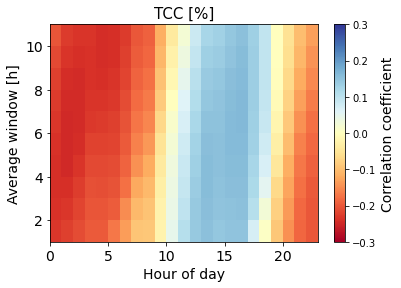

/home/jsperezc/py_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jsperezc/py_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


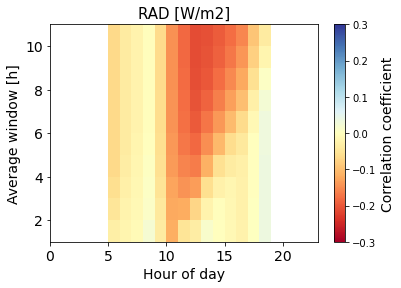

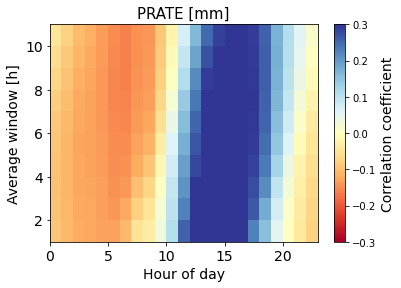

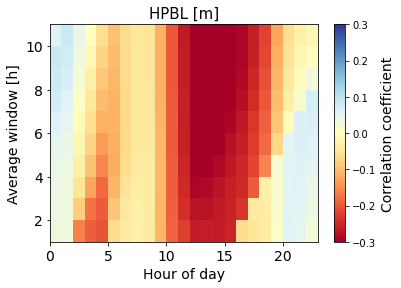

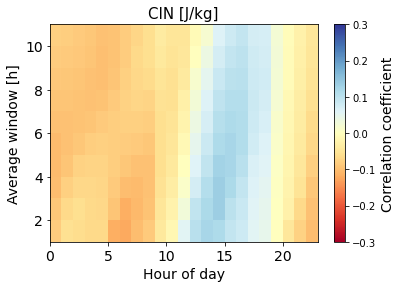

In [6]:
windows = np.arange(1,12)
hours = np.arange(0,24)

for variable_i,variable in enumerate(keys_gfs):
    matriz_corrs = np.zeros([len(windows),len(hours)])

    for window in windows:
        for hour_temp in hours:
            df_rolling = df_GFS_hourly.rolling(str(window)+'H',center=False, min_periods = window).mean()[variable]
            df_temp = pd.concat([df_rolling[df_rolling.index.hour==hour_temp],
                    df_hourly_chem[df_hourly_chem.index.hour==hour_temp].PM25_stations],axis = 1)
            df_temp = df_temp.dropna()
            corr = np.corrcoef(df_temp.iloc[:,0].values,df_temp.iloc[:,1].values)[0][1]
            matriz_corrs[window-1,hour_temp] = corr
    if variable == 'rad':
        matriz_corrs[:,:5] = np.nan
        matriz_corrs[:,19:] = np.nan
    plt.close('all')
    plt.title(variable.upper() +' ['+ units[variable_i]+']',fontsize=15)
    plt.pcolormesh(hours,windows,matriz_corrs,vmin = -0.3,vmax=0.3,cmap = 'RdYlBu')
    np.save('/var/data1/AQ_Forecast_DATA/historic/GFS/correlations/CorrsAnomsGFS_'+variable+'_v3.npy', matriz_corrs)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Hour of day',fontsize=14)
    plt.ylabel('Average window [h]', fontsize=14)
    cbar = plt.colorbar()
    cbar.set_label('Correlation coefficient',fontsize=14)
#     plt.savefig('Figures/Characterization/Meteo/Corrs_'+keys_gfs[variable_i]+'.png',bbox_inches='tight')
    plt.show()

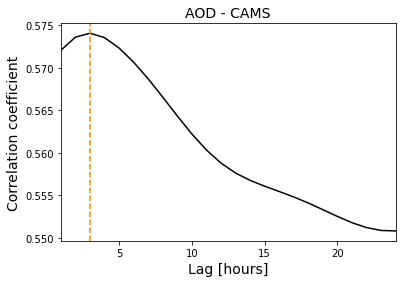

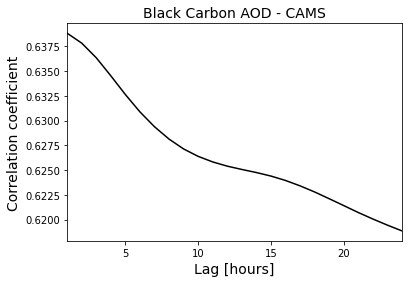

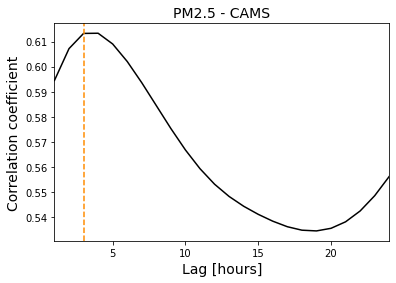

In [7]:
names_cams = ['AOD - CAMS','Black Carbon AOD - CAMS','PM2.5 - CAMS']

for i,var_cams in enumerate(df_hourly_chem.keys()[1:]):
    corrs_temp = []
    for lag in range(1,25):
        df_roll = df_hourly_chem[var_cams].rolling(lag).mean()
        conc = pd.concat([df_roll,df_hourly_chem.PM25_stations],axis=1).dropna()
        corrs_temp.append(np.corrcoef(conc.iloc[:,0],conc.iloc[:,1])[0,1])

    plt.plot(np.arange(1,25),corrs_temp,color='k')
    plt.axvline([3,0,3][i],color='darkorange',ls = '--',label = 'Max. Correlation')
    plt.title(names_cams[i],fontsize=14)
    plt.xlabel('Lag [hours]',fontsize=14)
    plt.ylabel('Correlation coefficient',fontsize=14)
    plt.xlim(1,24)
    plt.show()

## IFRP

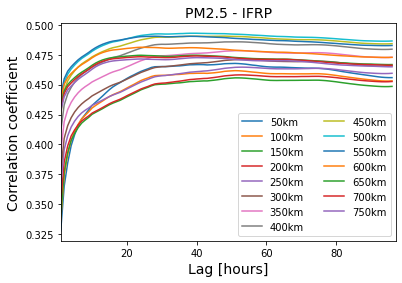

In [5]:
ifrp = pd.read_csv("/var/data1/AQ_Forecast_DATA/historic/Fires/Processed/IFRP_Radios_800hpa_4dias.csv", 
                   usecols=[str(i) for i in np.arange(16)],index_col=0,parse_dates=True)
ifrp.index = ifrp.index-dt.timedelta(hours=5)
ifrp.columns = np.arange(50, 800, 50).astype(str)


for val in ifrp.columns:
    ifrp_temp = ifrp[[val]]

    corrs_temp = []
    for lag in range(1,97):
        df_roll = ifrp_temp[val].rolling(lag).mean()
        conc = pd.concat([df_roll,df_hourly_chem.PM25_stations],axis=1).dropna()
    #     corrs_temp.append(stats.spearmanr(conc.iloc[:,0],conc.iloc[:,1]).correlation)
        corrs_temp.append(np.corrcoef(conc.iloc[:,0],conc.iloc[:,1])[0,1])

    plt.plot(np.arange(1,97),corrs_temp,label=val+'km')
    plt.legend(ncol=2)
    plt.title('PM2.5 - IFRP',fontsize=14)
    plt.xlabel('Lag [hours]',fontsize=14)
    plt.ylabel('Correlation coefficient',fontsize=14)
    plt.xlim(1,97)
plt.show()

ifrp_optimal_50 = ifrp[['50']].rolling(24).mean()

In [6]:
### PREPARA DATOS DE ENTRADA

df_optimal_cams = pd.DataFrame(index = df_hourly_chem.index)
df_optimal_cams['aod'] = df_hourly_chem.aod.rolling(3).mean()
df_optimal_cams['bcaod'] = df_hourly_chem.bcaod.rolling(1).mean()
df_optimal_cams['pm2p5_cams'] = df_hourly_chem.pm2p5_cams.rolling(3).mean()

def get_optimal_window(variable,hour):
    return np.argmax(abs(np.load('/var/data1/AQ_Forecast_DATA/historic/GFS/correlations/CorrsAnomsGFS_'\
                                 +variable+'_v3.npy')[:,hour]))+1

df_optimal_gfs = pd.DataFrame(index = df_GFS_hourly.index)

for variable in keys_gfs:
    df_optimal_temp = copy.deepcopy(df_GFS_hourly[[variable]])
    for hour in range(0,24):
        optimal_window = get_optimal_window(variable,hour)
        df_optimal_temp[df_optimal_temp.index.hour == hour] = df_GFS_hourly[[variable]].rolling(optimal_window).mean()\
            [df_optimal_temp.index.hour == hour]
    df_optimal_gfs[variable] = df_optimal_temp

In [7]:
df_hour = pd.DataFrame(df_hourly_chem.index.hour, index = df_hourly_chem.index)
df_hour1 = np.sin(2*np.pi*(df_hour/24))
df_hour2 = np.cos(2*np.pi*(df_hour/24))

df_dow = pd.DataFrame(df_hourly_chem.index.dayofweek, index = df_hourly_chem.index)
df_dow1 = np.sin(2*np.pi*(df_dow/7))
df_dow2 = np.cos(2*np.pi*(df_dow/7))

df_doy = pd.DataFrame(df_hourly_chem.index.dayofyear, index = df_hourly_chem.index)
df_doy1 = np.sin(2*np.pi*(df_doy/365))
df_doy2 = np.cos(2*np.pi*(df_doy/365))

# 2. Organize and Select Input Features

In [8]:
max_lag = 48
x_shifts = pd.concat([df_hourly_chem.PM25_stations.shift(i) for i in range(max_lag,0,-1)],axis = 1).dropna()
x_shifts.columns = np.array(['PM_'+str(i).zfill(2) for i in range(max_lag,0,-1)])

aod_future = pd.DataFrame(np.array([df_optimal_cams[['aod']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_cams[['aod']].index,\
             columns = np.array(['AOD_'+str(i).zfill(2) for i in range(0,97,3)]))
bc_future = pd.DataFrame(np.array([df_optimal_cams[['bcaod']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_cams[['bcaod']].index,\
             columns = np.array(['BCAOD_'+str(i).zfill(2) for i in range(0,97,3)]))
pm2p5_future = bc_future = pd.DataFrame(np.array([df_optimal_cams[['pm2p5_cams']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_cams[['pm2p5_cams']].index,\
             columns = np.array(['PMCAMS_'+str(i).zfill(2) for i in range(0,97,3)]))

tcc_future = pd.DataFrame(np.array([df_optimal_gfs[['tcc']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['tcc']].index,\
             columns = np.array(['tcc_'+str(i).zfill(2) for i in range(0,97,3)]))
rad_future = pd.DataFrame(np.array([df_optimal_gfs[['rad']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['rad']].index,\
             columns = np.array(['rad_'+str(i).zfill(2) for i in range(0,97,3)]))
prate_future = pd.DataFrame(np.array([df_optimal_gfs[['prate']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['prate']].index,\
             columns = np.array(['prate_'+str(i).zfill(2) for i in range(0,97,3)]))
hpbl_future = pd.DataFrame(np.array([df_optimal_gfs[['hpbl']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['hpbl']].index,\
             columns = np.array(['hpbl_'+str(i).zfill(2) for i in range(0,97,3)]))
cin_future = pd.DataFrame(np.array([df_optimal_gfs[['cin']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['cin']].index,\
             columns = np.array(['cin_'+str(i).zfill(2) for i in range(0,97,3)]))


ifrp50_future = pd.DataFrame(np.array([ifrp_optimal_50[['50']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = ifrp_optimal_50[['50']].index,\
             columns = np.array(['ifrp50_'+str(i).zfill(2) for i in range(0,97,3)]))

dow1_future = pd.DataFrame(np.array([df_dow1[[0]].shift(-i).values for i in range(0,96,24)])[:,:,0].T,\
             index = df_dow1[[0]].index,\
             columns = np.array(['dow1_'+str(i).zfill(2) for i in range(0,96,24)]))
dow2_future = pd.DataFrame(np.array([df_dow2[[0]].shift(-i).values for i in range(0,96,24)])[:,:,0].T,\
             index = df_dow2[[0]].index,\
             columns = np.array(['dow2_'+str(i).zfill(2) for i in range(0,96,24)]))

hod1_future = pd.DataFrame(np.array([df_hour1[[0]].shift(-i).values for i in range(0,24,1)])[:,:,0].T,\
             index = df_hour1[[0]].index,\
             columns = np.array(['hod1_'+str(i).zfill(2) for i in range(0,24,1)]))
hod2_future = pd.DataFrame(np.array([df_hour2[[0]].shift(-i).values for i in range(0,24,1)])[:,:,0].T,\
             index = df_hour2[[0]].index,\
             columns = np.array(['hod2_'+str(i).zfill(2) for i in range(0,24,1)]))

y_future = pd.DataFrame(np.array([df_hourly_chem[['PM25_stations']].shift(-i).values for i in range(0,96)])[:,:,0].T,\
             index = df_hourly_chem[['PM25_stations']].index,\
             columns = np.array(['y_'+str(i).zfill(2) for i in range(0,96)]))

### try rolling mean output # this was a winner
pm_smoothed = df_hourly_chem[['PM25_stations']].rolling(26,min_periods=16).mean()
y_future_smoothed = pd.DataFrame(np.array([pm_smoothed.shift(-i).values for i in range(0,96)])[:,:,0].T,\
             index = pm_smoothed.index,\
             columns = np.array(['y_'+str(i).zfill(2) for i in range(0,96)]))


In [9]:
X = pd.concat([x_shifts,
aod_future,
#     bc_future, NO USAR NUNCA, DAÑAN EL PRONÓSTICO :C
#     pm2p5_future,
tcc_future,
#     rad_future, meh
prate_future,
hpbl_future,
#     cin_future, meh
ifrp50_future,
dow1_future,
dow2_future,
hod1_future,
hod2_future],axis=1).dropna()

Y = y_future_smoothed.loc[X.index] 
XY = pd.concat([X,Y],axis=1).dropna()
X = XY.iloc[:,:-96]
Y = XY.iloc[:,-96:]

## SMOGN

In [10]:
# Generar nueva columna con el valor promiedo de cada fila
Y['Mean'] = Y.mean(axis=1)
# Generar nueva columna con el mínimo valor de cada fila
Y['MinValue'] = Y.min(axis=1)
# Generar nueva columna con el máximo valor de cada fila
Y['MaxValue'] = Y.max(axis=1)

perc_5 = np.percentile(Y['Mean'],5)
perc_25 = np.percentile(Y['Mean'],25)
perc_75 = np.percentile(Y['Mean'],75)
perc_95 = np.percentile(Y['Mean'],95)

# Generar nueva columna
Y['NewValue'] = np.where(Y['Mean'] > perc_95, Y['MaxValue'],
                          np.where(Y['Mean'] < perc_5, Y['MinValue'], Y['Mean']))

#Agregamos la colummna a predecir
X['Y'] = Y['NewValue']

[Text(0, 0, 'Mean'),
 Text(1, 0, 'MinValue'),
 Text(2, 0, 'MaxValue'),
 Text(3, 0, 'NewValue')]

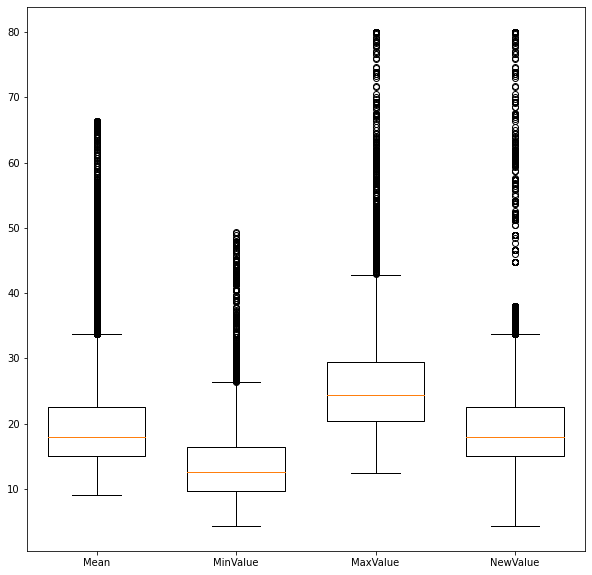

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.boxplot(Y['Mean'],positions=[0],widths = 0.7)
ax.boxplot(Y['MinValue'],positions=[1],widths = 0.7)
ax.boxplot(Y['MaxValue'],positions=[2],widths = 0.7)
ax.boxplot(Y['NewValue'],positions=[3],widths = 0.7)
names_vars = ['Mean','MinValue','MaxValue','NewValue']
ax.set_xticklabels(names_vars)

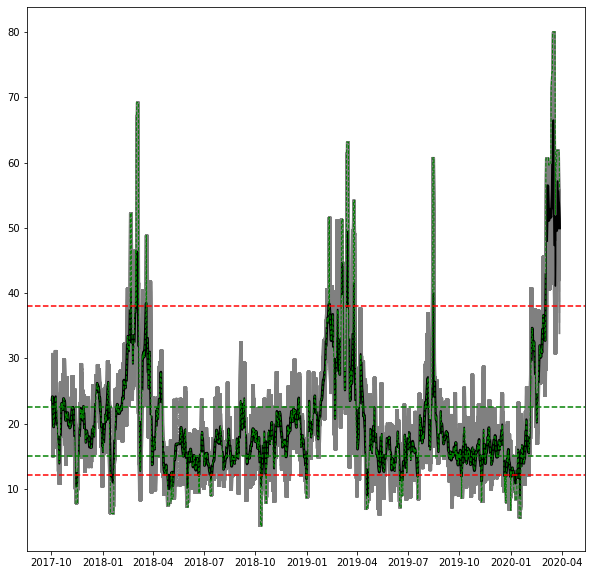

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for col in Y.keys():
    if  col == 'Mean':
        ax.plot(Y[col], lw = 3, color = '#000000')
    elif  col == 'NewValue':
        ax.plot(Y[col], lw = 1, color = 'green', ls ='--')
    else:
        ax.plot(Y[col], color = 'gray')
plt.axhline(y = perc_5, color = 'red', linestyle = '--')
plt.axhline(y = perc_25, color = 'green', linestyle = '--')
plt.axhline(y = perc_75, color = 'green', linestyle = '--')
plt.axhline(y = perc_95, color = 'red', linestyle = '--')

In [13]:
fechas = X.index
X.index = np.arange(0,len(X))

In [14]:
## specify phi relevance values
rg_mtrx = [
    [10, 1, 0],  ## over-sample ("minority")  
    [20, 0, 0],
    [30, 0, 0],
    [40, 0, 0],
    [50, 1, 0],  ## over-sample ("minority")
]

In [15]:
## conduct smogn
X_smogn = smogn.smoter(
    
    ## main arguments
    data = X,           ## pandas dataframe
    y = 'Y',          ## string ('header name')
    k = 7,                    ## positive integer (k < n)
    pert = 0.04,              ## real number (0 < R < 1)
    samp_method = 'extreme',  ## string ('balance' or 'extreme')
    drop_na_col = True,       ## boolean (True or False)
    drop_na_row = True,       ## boolean (True or False)
    replace = False,          ## boolean (True or False)

    ## phi relevance arguments
    rel_thres = 0.10,         ## real number (0 < R < 1)
    rel_method = 'manual',    ## string ('auto' or 'manual')
    #rel_xtrm_type = 'both', ## unused (rel_method = 'manual')
    # rel_coef = 1.50,        ## unused (rel_method = 'manual')
    rel_ctrl_pts_rg = rg_mtrx ## 2d array (format: [x, y])
)

r_index: 100%|##########| 520/520 [00:04<00:00, 118.71it/s]


In [ ]:
X_smogn_auto = smogn.smoter(
    
    ## main arguments
    data = X,           ## pandas dataframe
    y = 'Y',          ## string ('header name')
    k = 7,                    ## positive integer (k < n)
    samp_method = 'extreme',  ## string ('balance' or 'extreme')
    drop_na_col = True,       ## boolean (True or False)
    drop_na_row = True,       ## boolean (True or False)
    ## phi relevance arguments
    rel_thres = 0.10,         ## positive real number (0 < R < 1)
    rel_method = 'auto',      ## string ('auto' or 'manual')
    rel_xtrm_type = 'both',   ## string ('low' or 'both' or 'high')
    rel_coef = 2.5           ## positive real number (0 < R)
)

dist_matrix:   9%|8         | 512/5850 [1:56:10<19:59:11, 13.48s/it]

In [347]:
len(X), len(X_smogn)

(20820, 33799)

In [349]:
len(X[X.Y < 10]), len(X_smogn[X_smogn.Y < 10])

(1040, 1389)

In [350]:
len(X[X.Y > 60]), len(X_smogn[X_smogn.Y > 60])

(638, 7095)

[Text(0, 0, 'Mean'),
 Text(1, 0, 'MinValue'),
 Text(2, 0, 'MaxValue'),
 Text(3, 0, 'NewValue'),
 Text(4, 0, 'Remuestreo')]

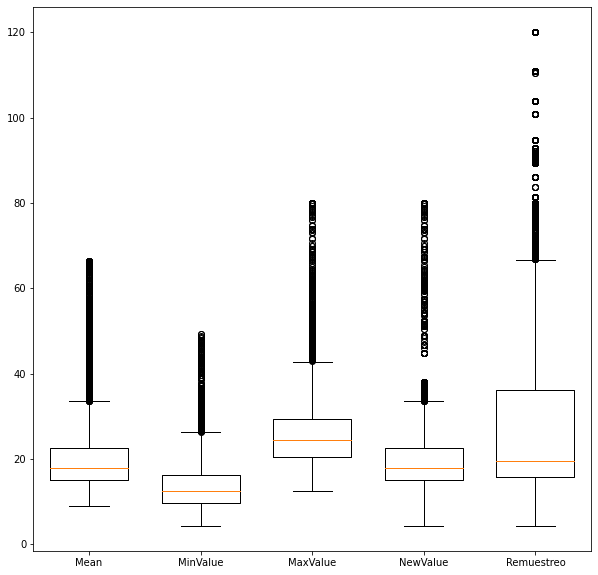

In [348]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.boxplot(Y['Mean'],positions=[0],widths = 0.7)
ax.boxplot(Y['MinValue'],positions=[1],widths = 0.7)
ax.boxplot(Y['MaxValue'],positions=[2],widths = 0.7)
ax.boxplot(Y['NewValue'],positions=[3],widths = 0.7)
ax.boxplot(X_smogn['Y'],positions=[4],widths = 0.7)
names_vars = ['Mean','MinValue','MaxValue','NewValue','Remuestreo']
ax.set_xticklabels(names_vars)

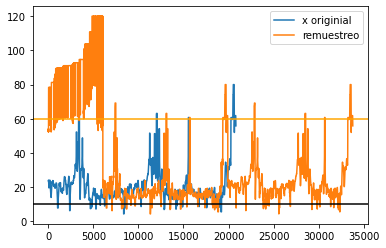

In [355]:
plt.plot(X['Y'].values, label = 'x originial')
plt.plot(X_smogn.reset_index()['Y'], label = 'remuestreo')
plt.axhline(y=10,color = 'black')
plt.axhline(y=60,color = 'orange')
plt.legend()

In [143]:
housing_smogn = smogn.smoter(
    
    ## main arguments
    data = X,           ## pandas dataframe
    y = 'Y',          ## string ('header name')
    k = 7,                    ## positive integer (k < n)
    samp_method = 'extreme',  ## string ('balance' or 'extreme')
    drop_na_col = True,       ## boolean (True or False)
    drop_na_row = True,       ## boolean (True or False)
    ## phi relevance arguments
    rel_thres = 0.80,         ## positive real number (0 < R < 1)
    rel_method = 'auto',      ## string ('auto' or 'manual')
    rel_xtrm_type = 'both',   ## string ('low' or 'both' or 'high')
    rel_coef = 2.5           ## positive real number (0 < R)
)

dist_matrix:   1%|1         | 28/2092 [02:23<2:56:28,  5.13s/it]


KeyboardInterrupt: 

In [125]:
len(X), len(housing_smogn)

(20820, 1727)

In [120]:
len(X[X.Y < 12]), len(housing_smogn[housing_smogn.Y < 12])

(1041, 0)

In [121]:
len(X[X.Y > 50]), len(housing_smogn[housing_smogn.Y > 50])

(991, 0)

[Text(0, 0, 'Mean'),
 Text(1, 0, 'MinValue'),
 Text(2, 0, 'MaxValue'),
 Text(3, 0, 'NewValue'),
 Text(4, 0, 'Remuestreo')]

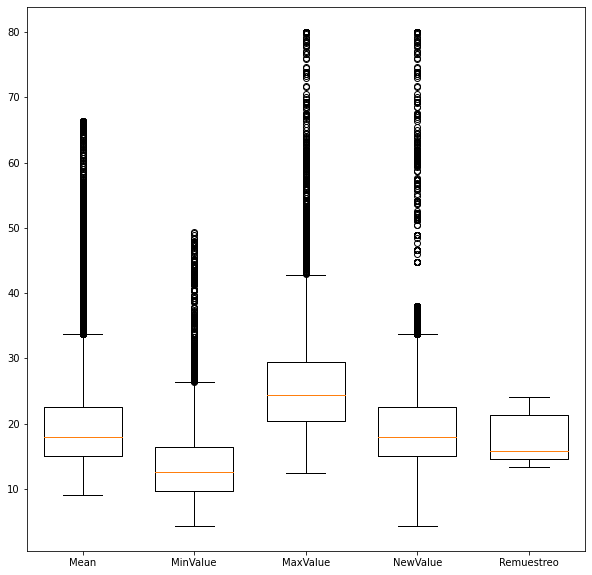

In [122]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.boxplot(Y['Mean'],positions=[0],widths = 0.7)
ax.boxplot(Y['MinValue'],positions=[1],widths = 0.7)
ax.boxplot(Y['MaxValue'],positions=[2],widths = 0.7)
ax.boxplot(Y['NewValue'],positions=[3],widths = 0.7)
ax.boxplot(housing_smogn['Y'],positions=[4],widths = 0.7)
names_vars = ['Mean','MinValue','MaxValue','NewValue','Remuestreo']
ax.set_xticklabels(names_vars)

In [19]:
X_short = X.iloc[:1000]
Y_short = Y.iloc[:1000]

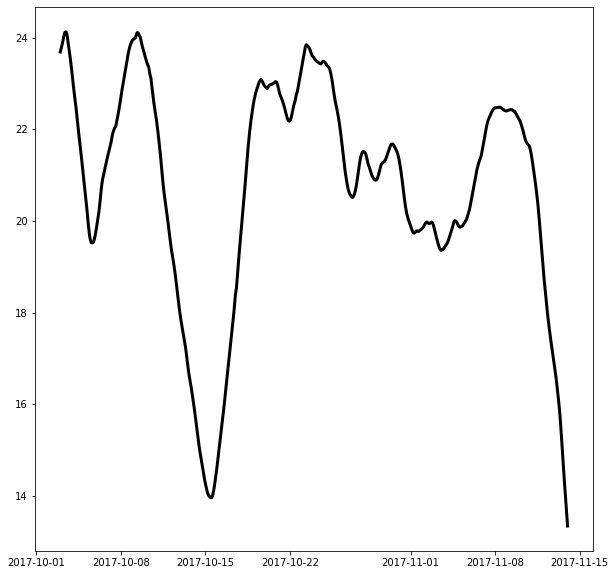

In [43]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.plot(Y_short[col], lw = 3, color = '#000000')
#plt.axhline(y = perc_5, color = 'red', linestyle = '--')
#plt.axhline(y = perc_25, color = 'green', linestyle = '--')
#plt.axhline(y = perc_75, color = 'green', linestyle = '--')
#plt.axhline(y = perc_95, color = 'red', linestyle = '--')

In [32]:
housing_smogn = smogn.smoter(
    
    ## main arguments
    data = X_short,           ## pandas dataframe
    y = 'Y',          ## string ('header name')
    k = 9,                    ## positive integer (k < n)
    samp_method = 'extreme',  ## string ('balance' or 'extreme')
    drop_na_col = True,       ## boolean (True or False)
    drop_na_row = True,       ## boolean (True or False)
    ## phi relevance arguments
    rel_thres = 0.70,         ## positive real number (0 < R < 1)
    rel_method = 'auto',      ## string ('auto' or 'manual')
    rel_xtrm_type = 'both',   ## string ('low' or 'both' or 'high')
    rel_coef = 2.25           ## positive real number (0 < R)
)

r_index: 100%|##########| 70/70 [00:00<00:00, 80.08it/s]


In [33]:
len(X_short), len(housing_smogn)

(2000, 3472)

[Text(0, 0, 'Mean'),
 Text(1, 0, 'MinValue'),
 Text(2, 0, 'MaxValue'),
 Text(3, 0, 'NewValue'),
 Text(4, 0, 'Remuestreo')]

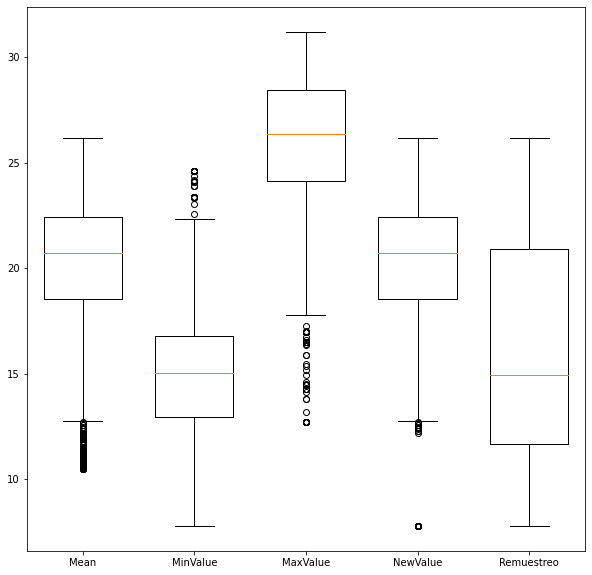

In [58]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.boxplot(Y_short['Mean'],positions=[0],widths = 0.7)
ax.boxplot(Y_short['MinValue'],positions=[1],widths = 0.7)
ax.boxplot(Y_short['MaxValue'],positions=[2],widths = 0.7)
ax.boxplot(Y_short['NewValue'],positions=[3],widths = 0.7)
ax.boxplot(housing_smogn['Y'],positions=[4],widths = 0.7)
names_vars = ['Mean','MinValue','MaxValue','NewValue','Remuestreo']
ax.set_xticklabels(names_vars)

In [88]:
## specify phi relevance values
rg_mtrx = [

    [15, 1, 0],  ## over-sample ("minority")  
    [20, 0, 0],
    [22, 1, 0],  ## over-sample ("minority")
]

In [89]:
## conduct smogn
housing_smogn_2 = smogn.smoter(
    
    ## main arguments
    data = X_short,           ## pandas dataframe
    y = 'Y',          ## string ('header name')
    k = 7,                    ## positive integer (k < n)
    pert = 0.04,              ## real number (0 < R < 1)
    samp_method = 'extreme',  ## string ('balance' or 'extreme')
    drop_na_col = True,       ## boolean (True or False)
    drop_na_row = True,       ## boolean (True or False)
    replace = False,          ## boolean (True or False)

    ## phi relevance arguments
    rel_thres = 0.80,         ## real number (0 < R < 1)
    rel_method = 'manual',    ## string ('auto' or 'manual')
    # rel_xtrm_type = 'both', ## unused (rel_method = 'manual')
    # rel_coef = 1.50,        ## unused (rel_method = 'manual')
    rel_ctrl_pts_rg = rg_mtrx ## 2d array (format: [x, y])
)

r_index: 100%|##########| 64/64 [00:00<00:00, 75.54it/s]


In [85]:
len(X_short), len(housing_smogn_2)

(1000, 1707)

[Text(0, 0, 'Mean'),
 Text(1, 0, 'MinValue'),
 Text(2, 0, 'MaxValue'),
 Text(3, 0, 'NewValue'),
 Text(4, 0, 'Remuestreo')]

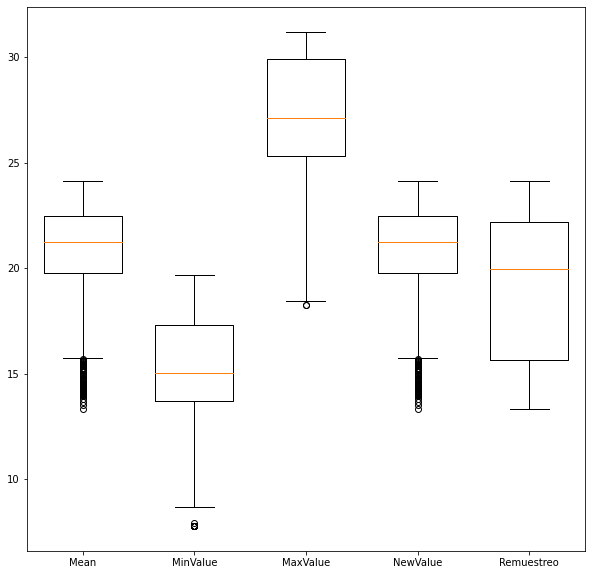

In [90]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.boxplot(Y_short['Mean'],positions=[0],widths = 0.7)
ax.boxplot(Y_short['MinValue'],positions=[1],widths = 0.7)
ax.boxplot(Y_short['MaxValue'],positions=[2],widths = 0.7)
ax.boxplot(Y_short['NewValue'],positions=[3],widths = 0.7)
ax.boxplot(housing_smogn_2['Y'],positions=[4],widths = 0.7)
names_vars = ['Mean','MinValue','MaxValue','NewValue','Remuestreo']
ax.set_xticklabels(names_vars)

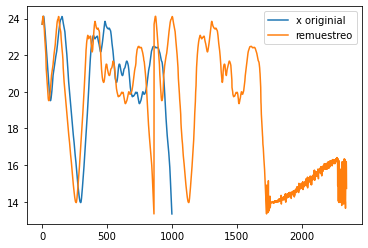

In [91]:
plt.plot(X_short['Y'].values, label = 'x originial')
plt.plot(housing_smogn_2.reset_index()['Y'], label = 'remuestreo')
plt.legend()

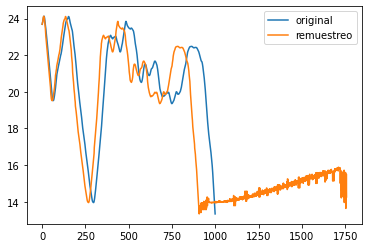

In [48]:
plt.plot(Y_short['NewValue'].values, label = 'original')
plt.plot(housing_smogn_2.reset_index()['Y'], label = 'remuestreo')
plt.legend()

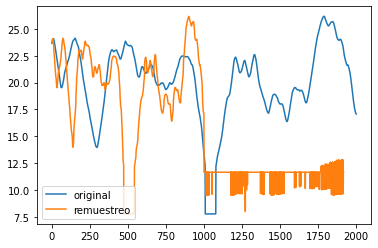

In [75]:
plt.plot(Y_short['NewValue'].values, label = 'original')
plt.plot(housing_smogn_2.reset_index()['Y'], label = 'remuestreo')
plt.legend()

# 3. Hyperparameter tuning for gb

In [91]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import itertools

In [92]:
def cross_validate_estimator(X,Y,estimator,n_splits = 5,gap=96):
    #Scale
    scaler_x = RobustScaler().fit(X)
    scaler_y = RobustScaler().fit(Y)
    X_scaled = scaler_x.transform(X)
    Y_scaled = scaler_y.transform(Y) 
    
    #Get splits
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)
    
    mses=[]
    for train_cv, test_cv in tscv.split(X=X_scaled):
        X_train_temp = X_scaled[train_cv]
        Y_train_temp = Y_scaled[train_cv]

        X_test_temp = X_scaled[test_cv]
        Y_test_temp = Y_scaled[test_cv]

        estimator.fit(X_train_temp,Y_train_temp)

        y_model = estimator.predict(X_test_temp)
        y_model = scaler_y.inverse_transform(y_model)
        y_val = scaler_y.inverse_transform(Y_test_temp)
        mses.append(mean_squared_error(y_model,y_val))
    return np.mean(mses)

## 3.1 Bagging

In [93]:
param_grid = {
    'task': ['train'], 
    'objective': ['regression'],
    'subsample': [1,0.8,0.6,0.4],
    'subsample_freq':[1],
#     'num_leaves': [5,10,20,40,80,160,320],
#     'min_data_in_leaf':[20,40,80,160,320],
#     'max_depth': [5,10,20,40],
    'extra_trees':['true'],            
    'verbose': [-1],
    'n_jobs':[1]}

keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [94]:
MSE_estimators = []
for estimator_i in range(len(permutations_dicts)):
    estimator_temp = MultiOutputRegressor(lgb.LGBMRegressor(**permutations_dicts[estimator_i]), n_jobs=20)
    MSE_estimators.append(cross_validate_estimator(X,Y,estimator_temp))
    print('---- '+str(estimator_i)+' ----')
    print(permutations_dicts[estimator_i])
    print(np.sqrt(MSE_estimators[estimator_i]))

---- 0 ----
{'task': 'train', 'objective': 'regression', 'subsample': 1, 'subsample_freq': 1, 'extra_trees': 'true', 'verbose': -1, 'n_jobs': 1}
4.710073663790161
---- 1 ----
{'task': 'train', 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 1, 'extra_trees': 'true', 'verbose': -1, 'n_jobs': 1}
4.714025517394115
---- 2 ----
{'task': 'train', 'objective': 'regression', 'subsample': 0.6, 'subsample_freq': 1, 'extra_trees': 'true', 'verbose': -1, 'n_jobs': 1}
4.713686509483224
---- 3 ----
{'task': 'train', 'objective': 'regression', 'subsample': 0.4, 'subsample_freq': 1, 'extra_trees': 'true', 'verbose': -1, 'n_jobs': 1}
4.720082733662294


## 3.2 Num_leaves

In [95]:
param_grid = {
    'task': ['train'], 
    'objective': ['regression'],
#     'bagging_fraction': [1,0.8,0.6,0.4],
#     'bagging_freq':[1],
    'num_leaves': [5,10,20,40,80],
#     'min_data_in_leaf':[20,40,80,160,320],
#     'max_depth': [5,10,20,40],
    'extra_trees':['true'],
    'boosting':['gbdt'],#try dart later             
    'verbose': [-1],
    'n_jobs':[1]}

keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [96]:
MSE_estimators = []
for estimator_i in range(len(permutations_dicts)):
    estimator_temp = MultiOutputRegressor(lgb.LGBMRegressor(**permutations_dicts[estimator_i]), n_jobs=20)
    MSE_estimators.append(cross_validate_estimator(X,Y,estimator_temp))
    print('---- '+str(estimator_i)+' ----')
    print(permutations_dicts[estimator_i])
    print(np.sqrt(MSE_estimators[estimator_i]))

---- 0 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 5, 'extra_trees': 'true', 'boosting': 'gbdt', 'verbose': -1, 'n_jobs': 1}
4.365406922268502
---- 1 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 10, 'extra_trees': 'true', 'boosting': 'gbdt', 'verbose': -1, 'n_jobs': 1}
4.526348813577604
---- 2 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 20, 'extra_trees': 'true', 'boosting': 'gbdt', 'verbose': -1, 'n_jobs': 1}
4.644336892041475
---- 3 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 40, 'extra_trees': 'true', 'boosting': 'gbdt', 'verbose': -1, 'n_jobs': 1}
4.743775618538083
---- 4 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 80, 'extra_trees': 'true', 'boosting': 'gbdt', 'verbose': -1, 'n_jobs': 1}
4.806050483611877


## 3.3 min_data_in_leaf

In [97]:
param_grid = {
    'task': ['train'], 
    'objective': ['regression'],
#     'bagging_fraction': [1,0.8,0.6,0.4],
#     'bagging_freq':[1],
    'num_leaves': [5],
    'min_data_in_leaf':[20,40,80,160,320],
#     'max_depth': [5,10,20,40],
    'extra_trees':['true'],            
    'verbose': [-1],
    'n_jobs':[1]}

keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [98]:
MSE_estimators = []
for estimator_i in range(len(permutations_dicts)):
    estimator_temp = MultiOutputRegressor(lgb.LGBMRegressor(**permutations_dicts[estimator_i]), n_jobs=20)
    MSE_estimators.append(cross_validate_estimator(X,Y,estimator_temp))
    print('---- '+str(estimator_i)+' ----')
    print(permutations_dicts[estimator_i])
    print(np.sqrt(MSE_estimators[estimator_i]))

---- 0 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 5, 'min_data_in_leaf': 20, 'extra_trees': 'true', 'verbose': -1, 'n_jobs': 1}
4.365406922268502
---- 1 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 5, 'min_data_in_leaf': 40, 'extra_trees': 'true', 'verbose': -1, 'n_jobs': 1}
4.378109810372522
---- 2 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 5, 'min_data_in_leaf': 80, 'extra_trees': 'true', 'verbose': -1, 'n_jobs': 1}
4.354754548858595
---- 3 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 5, 'min_data_in_leaf': 160, 'extra_trees': 'true', 'verbose': -1, 'n_jobs': 1}
4.39228805413442
---- 4 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 5, 'min_data_in_leaf': 320, 'extra_trees': 'true', 'verbose': -1, 'n_jobs': 1}
4.437320558188156


## 3.3 max_depth

In [99]:
param_grid = {
    'task': ['train'], 
    'objective': ['regression'],
#     'bagging_fraction': [1,0.8,0.6,0.4],
#     'bagging_freq':[1],
    'num_leaves': [5],
    'min_data_in_leaf':[80],
    'max_depth': [5,10,20,40],
    'verbose': [-1],
    'n_jobs':[1]}

keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [100]:
MSE_estimators = []
for estimator_i in range(len(permutations_dicts)):
    estimator_temp = MultiOutputRegressor(lgb.LGBMRegressor(**permutations_dicts[estimator_i]), n_jobs=20)
    MSE_estimators.append(cross_validate_estimator(X,Y,estimator_temp))
    print('---- '+str(estimator_i)+' ----')
    print(permutations_dicts[estimator_i])
    print(np.sqrt(MSE_estimators[estimator_i]))

---- 0 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 5, 'min_data_in_leaf': 80, 'max_depth': 5, 'verbose': -1, 'n_jobs': 1}
4.330733917811335
---- 1 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 5, 'min_data_in_leaf': 80, 'max_depth': 10, 'verbose': -1, 'n_jobs': 1}
4.330733917811335
---- 2 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 5, 'min_data_in_leaf': 80, 'max_depth': 20, 'verbose': -1, 'n_jobs': 1}
4.330733917811335
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current

---- 3 ----
{'task': 'train', 'objective': 'regression', 'num_leaves': 5, 'min_data_in_leaf': 80, 'max_depth': 40, 'verbose': -1, 'n_jobs': 1}
4.330733917811335


## 3.4 Extra-trees

In [101]:
param_grid = {
    'task': ['train'], 
    'objective': ['regression'],
#     'bagging_fraction': [1,0.8,0.6,0.4],
#     'bagging_freq':[1],
    'num_leaves': [5],
    'min_data_in_leaf':[80],
#     'max_depth': [5,10,20,40],
    'extra_trees':['true','false'],
    'verbose': [-1],
    'n_jobs':[1]}

keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [102]:
MSE_estimators = []
for estimator_i in range(len(permutations_dicts)):
    estimator_temp = MultiOutputRegressor(lgb.LGBMRegressor(**permutations_dicts[estimator_i]), n_jobs=60)
    MSE_estimators.append(cross_validate_estimator(X,Y,estimator_temp))
    print('---- '+str(estimator_i)+' ----')
    print(permutations_dicts[estimator_i])
    print(np.sqrt(MSE_estimators[estimator_i]))

[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min

# 5. Save and train best estimator

In [103]:
final_estimator = MultiOutputRegressor(lgb.LGBMRegressor(**{'task': 'train',\
                                                            'objective': 'regression',\
                                                            'num_leaves': 5, \
                                                            'min_child_samples': 80, \
                                                            'extra_trees': 'false', \
                                                            'verbose': -1,\
                                                            'n_jobs':1}), n_jobs=20)

In [104]:
def train_estimator(X,Y,estimator,path_scaler_x=None,path_scaler_y=None,path_estimator=None):
    #Scale
    scaler_x = RobustScaler().fit(X)
    scaler_y = RobustScaler().fit(Y)
    X_scaled = scaler_x.transform(X)
    Y_scaled = scaler_y.transform(Y) 
    
    if path_scaler_x!=None:
        joblib.dump(scaler_x, open(path_scaler_x, 'wb'))
    if path_scaler_y!=None:
        joblib.dump(scaler_y, open(path_scaler_y, 'wb'))
        
    estimator.fit(X_scaled,Y_scaled)
    if path_estimator!=None:
        joblib.dump(estimator, open(path_estimator, 'wb'),compress=5)
        
    return estimator

In [105]:
final_estimator = train_estimator(X,Y,final_estimator,
                                 '/var/data1/AQ_Forecast_DATA/scalers/Mean_X.scl',
                                 '/var/data1/AQ_Forecast_DATA/scalers/Mean_Y.scl',
                                 '/var/data1/AQ_Forecast_DATA/trained_estimators/Mean_GB_MO.mdl')

[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min

In [ ]:
model = joblib.load('/var/data1/AQ_Forecast_DATA/trained_estimators/Mean_GB_MO.mdl')

In [1]:
import smogn
import pandas

In [145]:

## load data
housing = pd.read_csv(

    ## http://jse.amstat.org/v19n3/decock.pdf
    'https://raw.githubusercontent.com/nickkunz/smogn/master/data/housing.csv'
)

In [151]:
housing

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


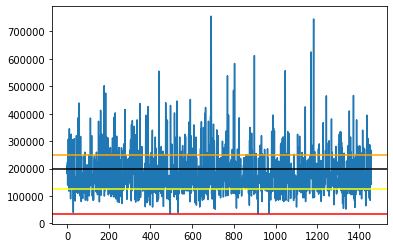

In [255]:
plt.plot(housing.SalePrice)
plt.axhline(y=35000, color = 'red')
plt.axhline(y=125000, color = 'yellow')
plt.axhline(y=200000, color = 'black')
plt.axhline(y=250000, color = 'orange')

In [337]:

## specify phi relevance values
rg_mtrx = [

    [50000,  1, 0],  ## over-sample ("minority")
    [100000, 0, 0],  ## under-sample ("majority")
    [200000, 0, 0],  ## under-sample ("majority")
    [300000, 0, 0],  ## under-sample ("majority")
    [400000, 0, 0],  ## under-sample ("majority")
    [600000, 1, 0],  ## under-sample
]

In [338]:
## conduct smogn
housing_smogn = smogn.smoter(
    
    ## main arguments
    data = housing,           ## pandas dataframe
    y = 'SalePrice',          ## string ('header name')
    k = 7,                    ## positive integer (k < n)
    pert = 0.04,              ## real number (0 < R < 1)
    samp_method = 'extreme',  ## string ('balance' or 'extreme')
    drop_na_col = True,       ## boolean (True or False)
    drop_na_row = True,       ## boolean (True or False)
    replace = False,          ## boolean (True or False)

    ## phi relevance arguments
    rel_thres = 0.9,         ## real number (0 < R < 1)
    rel_method = 'manual',    ## string ('auto' or 'manual')
    # rel_xtrm_type = 'both', ## unused (rel_method = 'manual')
    # rel_coef = 1.50,        ## unused (rel_method = 'manual')
    rel_ctrl_pts_rg = rg_mtrx ## 2d array (format: [x, y])
)

r_index: 100%|##########| 2/2 [00:00<00:00, 118.58it/s]


In [308]:
housing[-5:-1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [309]:
housing_smogn.iloc[-5:-1]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1445,24,70,C (all),8461,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,171,0,0,0,0,7,2008,WD,Abnorml,40006
1446,25,69,C (all),8527,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,167,0,0,0,0,6,2008,WD,Abnorml,39965
1447,57,69,C (all),8499,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,166,0,0,0,0,7,2008,WD,Abnorml,39786
1448,18,70,C (all),8437,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,169,0,0,0,0,6,2007,WD,Abnorml,40046


In [310]:
len(housing), len(housing_smogn)

(1460, 2910)

In [340]:
len(housing[housing['SalePrice'] < 50000]), len(housing_smogn[housing_smogn['SalePrice'] < 50000])

(5, 207)

In [341]:
len(housing[housing['SalePrice'] > 600000]), len(housing_smogn[housing_smogn['SalePrice'] > 600000])

(4, 802)

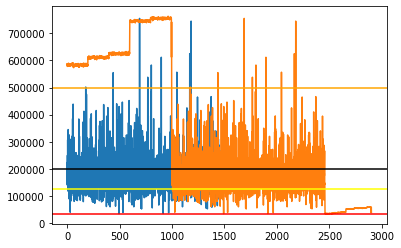

In [339]:
plt.plot(housing.SalePrice)
plt.plot(housing_smogn.reset_index()['SalePrice'])
plt.axhline(y=35000, color = 'red')
plt.axhline(y=125000, color = 'yellow')
plt.axhline(y=200000, color = 'black')
plt.axhline(y=500000, color = 'orange')

In [314]:
len(housing), len(housing_smogn)

(1460, 2910)

In [203]:
len(housing[housing['SalePrice'] < 125000]), len(housing_smogn[housing_smogn['SalePrice'] < 125000])

(301, 1050)

In [204]:
len(housing[housing['SalePrice'] > 200000]), len(housing_smogn[housing_smogn['SalePrice'] > 200000])

(427, 802)

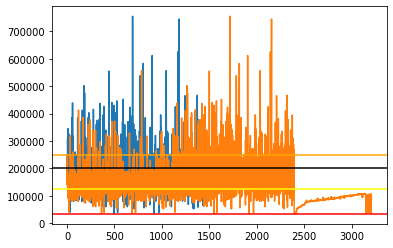

In [199]:
plt.plot(housing.SalePrice)
plt.plot(housing_smogn.reset_index()['SalePrice'])
plt.axhline(y=35000, color = 'red')
plt.axhline(y=125000, color = 'yellow')
plt.axhline(y=200000, color = 'black')
plt.axhline(y=250000, color = 'orange')